# M2608.001300 Machine Learning<br> Assignment #5 Final Projects (Pytorch)


Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them.

**For understanding of this work, please carefully look at given PPT file.**

Note: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import random

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
from PIL import Image
import resnet

Load datasets


In [2]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
NONE = ['NONE'] # label for empty space
ALL_CHAR_SET = NUMBER + ALPHABET + NONE
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 7

print(ALL_CHAR_SET.index('NONE'))

def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

# modified dataset class
class Mydataset(Dataset):
    def __init__(self, img_path, label_path, is_train=True, transform=None):
        self.path = img_path
        self.label_path = label_path
        if is_train: 
            self.img = os.listdir(self.path)[:1000]
            self.labels = open(self.label_path, 'r').read().split('\n')[:-1][:1000]
        else: 
            self.img = os.listdir(self.path)[:1000]
            self.labels = open(self.label_path, 'r').read().split('\n')[:-1][:1000]
        
        self.transform = transform
        self.max_length = MAX_CAPTCHA
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(f'{self.path}/{self.img[idx]}')
        img = img.convert('L')
        label = self.labels[idx]
        label_oh = []
        # one-hot for each character
        for i in range(self.max_length):
            if i < len(label):
                label_oh += encode(label[i])
            else:
                #label_oh += [0]*ALL_CHAR_SET_LEN
                label_oh += encode('NONE')
            
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

transform = transforms.Compose([
    transforms.Resize([160, 60]),
    transforms.ToTensor(),
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
# transforms.Normalize((0.1307, ), (0.3081, ))

##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################
])



36


In [3]:
"""Loading DATA"""
# Change to your own data folder path!
# gPath = '/content/drive/My Drive/Colab Notebooks/'
gPath = './'

train_ds = Mydataset(gPath+'Data/train/', gPath+'Data/train.txt',transform=transform)
test_ds = Mydataset(gPath+'Data/test/', gPath+'Data/test.txt', False, transform)
train_dl = DataLoader(train_ds, batch_size=128, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=4)

In [4]:
"""To CUDA for local run"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)


#GPUID = '4' # define GPUID
#os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)


cuda:0


Problem 1: Design LSTM model for catcha image recognition. (10 points)

[Captioning Images with CNN and RNN, using PyTorch](https://medium.com/@stepanulyanin/captioning-images-with-pytorch-bc592e5fd1a3)

In [5]:
class LSTM(nn.Module):
    def __init__(self, cnn_dim, hidden_size, vocab_size, num_layers=1):
        super(LSTM, self).__init__()
        
        # define the properties
        self.cnn_dim = cnn_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=self.vocab_size, hidden_size=hidden_size)
    
        # output fully connected layer
        self.fc_in = nn.Linear(in_features=self.cnn_dim, out_features=self.vocab_size)
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.vocab_size)
    
        # activations
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, features, captions):

        batch_size = features.size(0)
        cnn_dim = features.size(1)

        hidden_state = torch.zeros((batch_size, self.hidden_size)).cuda()
        cell_state = torch.zeros((batch_size, self.hidden_size)).cuda()
    
        # define the output tensor placeholder
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).cuda()

        # embed the captions
        captions_embed = self.embed(captions)
        
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
        # pass the caption word by word
        for t in range(captions.size(1)):
            # for the first time step the input is the feature vector
            if t == 0:
                features = features[:, :, 0, 0]
                inputs = self.fc_in(features)
                hidden_state, cell_state = self.lstm_cell(inputs, (hidden_state, cell_state))
                
            # for the 2nd+ time step, using teacher forcer
            else:
                hidden_state, cell_state = self.lstm_cell(captions_embed[:, t, :], (hidden_state, cell_state))
            
#             print(hidden_state.size())
            # output of the attention mechanism
            out = self.fc_out(hidden_state)
            # build the output tensor
            outputs[:, t, :] = out
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################
        return outputs[:,:,0]




Problem 2: 

*   1.Connect CNN model to the designed LSTM model.
*   2.Replace ResNet to your own CNN model from Assignment3.
* https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

In [6]:

##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################

# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 7)
        self.conv2 = nn.Conv2d(8, 16, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# betternet = Net()

"""ResNet"""
#CNN
betternet = resnet.resnet18(pretrained=False)
betternet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# betternet.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN, bias=True)
betternet.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)
betternet = betternet.to(device)
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

       
# LSTM
cnn_dim=512 #resnet18-512
hidden_size=8
vocab_size=37 #ALL_CHAR_SET_LEN
lstm = LSTM(cnn_dim=cnn_dim, hidden_size=hidden_size, vocab_size=vocab_size)
lstm = lstm.to(device)

# loss, optimizer
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################

class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        
    def forward(self, x, captions):
        _, feature = self.modelA(x)
        pred = self.modelB(feature, captions)
        return pred

model = MyEnsemble(betternet, lstm)
# print(model)

# loss_func = nn.MultiLabelSoftMarginLoss()
# cnn_optim = torch.optim.Adam(betternet.parameters(), lr=0.001)

loss_func = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Problem3: Find hyper-parameters.


In [7]:
import time
import matplotlib.pyplot as plt

"""TRAINING"""
print_interval = 5
max_epoch = 200

x_labels = []
y_labels = []

start_time = time.time()
for epoch in range(max_epoch):
    start_epoch_time = time.time()
    for step, i in enumerate(train_dl):
        start_step_time = time.time()
        img, label_oh, label = i
        img = Variable(img).cuda()
        label_oh = Variable(label_oh.long()).cuda()
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
        batch_size, _ = label_oh.shape
    
#         pred, feature = betternet(img)
#         loss = loss_func(pred, label_oh)
#         cnn_optim.zero_grad()
#         loss.backward()
#         cnn_optim.step()  
        
        pred = model(img, label_oh)
        loss = loss_func(pred, label_oh)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################
        if (epoch+1)%print_interval == 0:
            print('epoch:', epoch+1, 'step:', step+1, 'loss:', loss.item())
            y_labels.append(loss.item())
            x_labels.append('epoch:{}, step:{}'.format(epoch+1, step+1))
        if (epoch+1) % 20 == 0:
            torch.save(model, './models/BetterNet_LSTM_epoch{}.pth'.format(epoch+1))
    print('>> Epoch', epoch+1, 'elapsed time: {:.2f} sec'.format(time.time()-start_epoch_time))
print('Total Elapsed Time: {:.2f} sec'.format(time.time()-start_time))

>> Epoch 1 elapsed time: 1.70 sec
>> Epoch 2 elapsed time: 1.53 sec
>> Epoch 3 elapsed time: 1.51 sec
>> Epoch 4 elapsed time: 1.55 sec
epoch: 5 step: 1 loss: 0.05884035304188728
epoch: 5 step: 2 loss: 0.05680178850889206
epoch: 5 step: 3 loss: 0.05481883883476257
epoch: 5 step: 4 loss: 0.05292641371488571
epoch: 5 step: 5 loss: 0.05106658488512039
epoch: 5 step: 6 loss: 0.04943714663386345
epoch: 5 step: 7 loss: 0.04787255823612213
epoch: 5 step: 8 loss: 0.046319738030433655
>> Epoch 5 elapsed time: 1.55 sec
>> Epoch 6 elapsed time: 1.47 sec
>> Epoch 7 elapsed time: 1.47 sec
>> Epoch 8 elapsed time: 1.47 sec
>> Epoch 9 elapsed time: 1.48 sec
epoch: 10 step: 1 loss: 0.021118484437465668
epoch: 10 step: 2 loss: 0.020887982100248337
epoch: 10 step: 3 loss: 0.020544061437249184
epoch: 10 step: 4 loss: 0.020159199833869934
epoch: 10 step: 5 loss: 0.019660821184515953
epoch: 10 step: 6 loss: 0.01941952481865883
epoch: 10 step: 7 loss: 0.019157398492097855
epoch: 10 step: 8 loss: 0.018763154

/home/lucetre/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MyEnsemble. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/lucetre/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch: 20 step: 2 loss: 0.008522885851562023
epoch: 20 step: 3 loss: 0.008450414054095745
epoch: 20 step: 4 loss: 0.008295370265841484
epoch: 20 step: 5 loss: 0.007976464927196503
epoch: 20 step: 6 loss: 0.007989149540662766
epoch: 20 step: 7 loss: 0.007995249703526497
epoch: 20 step: 8 loss: 0.007762659806758165
>> Epoch 20 elapsed time: 1.92 sec
>> Epoch 21 elapsed time: 1.51 sec
>> Epoch 22 elapsed time: 1.49 sec
>> Epoch 23 elapsed time: 1.48 sec
>> Epoch 24 elapsed time: 1.50 sec
epoch: 25 step: 1 loss: 0.0055036386474967
epoch: 25 step: 2 loss: 0.005624980200082064
epoch: 25 step: 3 loss: 0.005569618195295334
epoch: 25 step: 4 loss: 0.00542638823390007
epoch: 25 step: 5 loss: 0.005104358308017254
epoch: 25 step: 6 loss: 0.005145411007106304
epoch: 25 step: 7 loss: 0.005182521417737007
epoch: 25 step: 8 loss: 0.004957329016178846
>> Epoch 25 elapsed time: 1.55 sec
>> Epoch 26 elapsed time: 1.48 sec
>> Epoch 27 elapsed time: 1.47 sec
>> Epoch 28 elapsed time: 1.52 sec
>> Epoch 29 e

epoch: 95 step: 5 loss: 0.0006318388623185456
epoch: 95 step: 6 loss: 0.0007615217473357916
epoch: 95 step: 7 loss: 0.0008899061940610409
epoch: 95 step: 8 loss: 0.0006285595009103417
>> Epoch 95 elapsed time: 1.51 sec
>> Epoch 96 elapsed time: 1.47 sec
>> Epoch 97 elapsed time: 1.50 sec
>> Epoch 98 elapsed time: 1.48 sec
>> Epoch 99 elapsed time: 1.46 sec
epoch: 100 step: 1 loss: 0.0008514835499227047
epoch: 100 step: 2 loss: 0.001114341663196683
epoch: 100 step: 3 loss: 0.0011132261715829372
epoch: 100 step: 4 loss: 0.0009806037414819002
epoch: 100 step: 5 loss: 0.0005839273799210787
epoch: 100 step: 6 loss: 0.0007152111502364278
epoch: 100 step: 7 loss: 0.0008452226174995303
epoch: 100 step: 8 loss: 0.0005810665315948427
>> Epoch 100 elapsed time: 1.93 sec
>> Epoch 101 elapsed time: 1.46 sec
>> Epoch 102 elapsed time: 1.47 sec
>> Epoch 103 elapsed time: 1.47 sec
>> Epoch 104 elapsed time: 1.47 sec
epoch: 105 step: 1 loss: 0.0008115405216813087
epoch: 105 step: 2 loss: 0.001077319029

epoch: 170 step: 3 loss: 0.0008440653327852488
epoch: 170 step: 4 loss: 0.000697401468642056
epoch: 170 step: 5 loss: 0.000257396895904094
epoch: 170 step: 6 loss: 0.0004039922496303916
epoch: 170 step: 7 loss: 0.0005498526152223349
epoch: 170 step: 8 loss: 0.0002567602205090225
>> Epoch 170 elapsed time: 1.70 sec
>> Epoch 171 elapsed time: 1.52 sec
>> Epoch 172 elapsed time: 1.50 sec
>> Epoch 173 elapsed time: 1.51 sec
>> Epoch 174 elapsed time: 1.51 sec
epoch: 175 step: 1 loss: 0.0005415061605162919
epoch: 175 step: 2 loss: 0.0008360549109056592
epoch: 175 step: 3 loss: 0.0008358012419193983
epoch: 175 step: 4 loss: 0.0006883914466015995
epoch: 175 step: 5 loss: 0.00024613464483991265
epoch: 175 step: 6 loss: 0.00039349141297861934
epoch: 175 step: 7 loss: 0.0005401350790634751
epoch: 175 step: 8 loss: 0.0002455268404446542
>> Epoch 175 elapsed time: 1.52 sec
>> Epoch 176 elapsed time: 1.49 sec
>> Epoch 177 elapsed time: 1.48 sec
>> Epoch 178 elapsed time: 1.48 sec
>> Epoch 179 elaps

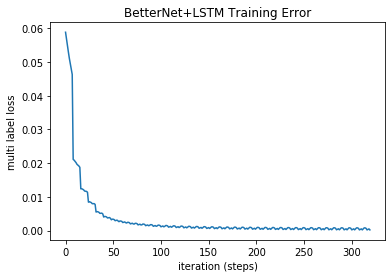

In [8]:
plt.plot(y_labels)
plt.xlabel('iteration (steps)')
plt.ylabel('multi label loss')
plt.title('BetterNet+LSTM Training Error')
# plt.show()

plt.savefig('BetterNet+LSTM.png', dpi = 300)

In [10]:
"""TEST"""
def get_char_count(arg1):
    c0 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    c5 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN*5:ALL_CHAR_SET_LEN*6])]
    c6 = ALL_CHAR_SET[np.argmax(arg1.cpu().tolist()[ALL_CHAR_SET_LEN*6:ALL_CHAR_SET_LEN*7])]
    return c0, c1, c2, c3, c4, c5, c6 

def get_str(ch_arr):
    ch_str = ''
    for ch in ch_arr:
        if ch == 'NONE':
            ch_str = ch_str + '_'
        else:
            ch_str = ch_str + ch
    return ch_str

char_correct = 0
word_correct = 0
total = 0

betternet.eval()
lstm.eval()
model.eval()

with torch.no_grad():
    for step, (img, label_oh, label) in enumerate(test_dl):
        char_count = 0
        img = Variable(img).cuda()
        label_oh = Variable(label_oh.long()).cuda()
        
#         pred, feature = betternet(img)
        pred = model(img, label_oh)

        label_len = label[0]
        pred = pred.squeeze(0)
        label_oh = label_oh.squeeze(0)
        
        c0,c1,c2,c3,c4,c5,c6 = get_char_count(pred.squeeze()) 
        d0,d1,d2,d3,d4,d5,d6 = get_char_count(label_oh) 
         
        c_arr = (c0, c1, c2, c3, c4, c5, c6)
        d_arr = (d0, d1, d2, d3, d4, d5, d6)
        
        c = '%s%s%s%s%s%s%s' % c_arr
        d = '%s%s%s%s%s%s%s' % d_arr
        
        c_str = get_str(c_arr)
        d_str = get_str(d_arr)
        
        print('PREDICT:', c_str, ', LABEL:', d_str)
    
        char_count += (c0==d0)+(c1==d1)+(c2==d2)+(c3==d3)+(c4==d4)+(c5==d5)+(c6==d6)
        char_correct += char_count

        if(bool(str(label[0]) in str(c))):
            word_correct+=1

        total += 1
       
print(100/7*char_correct/total)
print(100*word_correct/total)
"""END TEST"""

PREDICT: b9x____ , LABEL: b9x____
PREDICT: mb_____ , LABEL: mb_____
PREDICT: d5q7qh_ , LABEL: d5q7qh_
PREDICT: 6tl0kqv , LABEL: 6tl0kqv
PREDICT: t1_____ , LABEL: t1_____
PREDICT: avhjn3z , LABEL: avhjn3z
PREDICT: 74z0z__ , LABEL: 74z0z__
PREDICT: f1kfa__ , LABEL: f1kfa__
PREDICT: sripns_ , LABEL: sripns_
PREDICT: bg4____ , LABEL: bg4____
PREDICT: gmb45tz , LABEL: gmb45tz
PREDICT: sr5____ , LABEL: sr5____
PREDICT: 0nt____ , LABEL: 0nt____
PREDICT: lxfg98_ , LABEL: lxfg98_
PREDICT: 2b8o___ , LABEL: 2b8o___
PREDICT: kr25___ , LABEL: kr25___
PREDICT: fl_____ , LABEL: fl_____
PREDICT: 0tiwrd_ , LABEL: 0tiwrd_
PREDICT: k5_____ , LABEL: k5_____
PREDICT: 8k_____ , LABEL: 8k_____
PREDICT: ggin___ , LABEL: ggin___
PREDICT: qc6e___ , LABEL: qc6e___
PREDICT: giz6rv_ , LABEL: giz6rv_
PREDICT: tf15___ , LABEL: tf15___
PREDICT: 7jz____ , LABEL: 7jz____
PREDICT: v3zl9__ , LABEL: v3zl9__
PREDICT: p78ec__ , LABEL: p78ec__
PREDICT: 7rh____ , LABEL: 7rh____
PREDICT: exqo___ , LABEL: exqo___
PREDICT: yrs__

PREDICT: sj_____ , LABEL: sj_____
PREDICT: 1suyf8_ , LABEL: 1suyf8_
PREDICT: fblzo__ , LABEL: fblzo__
PREDICT: gvlhn__ , LABEL: gvlhn__
PREDICT: 0jj7w__ , LABEL: 0jj7w__
PREDICT: e4o89r_ , LABEL: e4o89r_
PREDICT: clwllf0 , LABEL: clwllf0
PREDICT: nq_____ , LABEL: nq_____
PREDICT: oljje__ , LABEL: oljje__
PREDICT: wjrvnu_ , LABEL: wjrvnu_
PREDICT: 6k8s94_ , LABEL: 6k8s94_
PREDICT: pjd____ , LABEL: pjd____
PREDICT: ekgvm__ , LABEL: ekgvm__
PREDICT: bo4m0__ , LABEL: bo4m0__
PREDICT: ultrlr_ , LABEL: ultrlr_
PREDICT: t1_____ , LABEL: t1_____
PREDICT: kq865m_ , LABEL: kq865m_
PREDICT: 5zw8___ , LABEL: 5zw8___
PREDICT: 3d_____ , LABEL: 3d_____
PREDICT: blvaodq , LABEL: blvaodq
PREDICT: 0myq___ , LABEL: 0myq___
PREDICT: 4qdr___ , LABEL: 4qdr___
PREDICT: ssj____ , LABEL: ssj____
PREDICT: y7_____ , LABEL: y7_____
PREDICT: 1lxjdnl , LABEL: 1lxjdnl
PREDICT: szg____ , LABEL: szg____
PREDICT: ac8____ , LABEL: ac8____
PREDICT: 8qb____ , LABEL: 8qb____
PREDICT: 5o_____ , LABEL: 5o_____
PREDICT: lch0n

PREDICT: e9ab___ , LABEL: e9ab___
PREDICT: lsr____ , LABEL: lsr____
PREDICT: hvhj5__ , LABEL: hvhj5__
PREDICT: d76____ , LABEL: d76____
PREDICT: 502tru_ , LABEL: 502tru_
PREDICT: 33mykb_ , LABEL: 33mykb_
PREDICT: 8fbh___ , LABEL: 8fbh___
PREDICT: 2ase___ , LABEL: 2ase___
PREDICT: axi1m__ , LABEL: axi1m__
PREDICT: 43_____ , LABEL: 43_____
PREDICT: 7jy____ , LABEL: 7jy____
PREDICT: j9yl___ , LABEL: j9yl___
PREDICT: fu_____ , LABEL: fu_____
PREDICT: yv2____ , LABEL: yv2____
PREDICT: 27f____ , LABEL: 27f____
PREDICT: i1u____ , LABEL: i1u____
PREDICT: j0ty___ , LABEL: j0ty___
PREDICT: qba4tor , LABEL: qba4tor
PREDICT: cai____ , LABEL: cai____
PREDICT: vf_____ , LABEL: vf_____
PREDICT: sdy____ , LABEL: sdy____
PREDICT: 1wk2pi_ , LABEL: 1wk2pi_
PREDICT: 7v_____ , LABEL: 7v_____
PREDICT: 8rvuoi_ , LABEL: 8rvuoi_
PREDICT: aa_____ , LABEL: aa_____
PREDICT: 79cnkb_ , LABEL: 79cnkb_
PREDICT: 981o0cz , LABEL: 981o0cz
PREDICT: 2k_____ , LABEL: 2k_____
PREDICT: 98_____ , LABEL: 98_____
PREDICT: tg___

PREDICT: jlh____ , LABEL: jlh____
PREDICT: rbam3rb , LABEL: rbam3rb
PREDICT: v8_____ , LABEL: v8_____
PREDICT: u75mm__ , LABEL: u75mm__
PREDICT: x6thn4h , LABEL: x6thn4h
PREDICT: 6c8n___ , LABEL: 6c8n___
PREDICT: vohcc__ , LABEL: vohcc__
PREDICT: 0f3ad__ , LABEL: 0f3ad__
PREDICT: a8wmu__ , LABEL: a8wmu__
PREDICT: 1dd4___ , LABEL: 1dd4___
PREDICT: e0hx___ , LABEL: e0hx___
PREDICT: af7g___ , LABEL: af7g___
PREDICT: x3nr9__ , LABEL: x3nr9__
PREDICT: wd_____ , LABEL: wd_____
PREDICT: a2_____ , LABEL: a2_____
PREDICT: vd_____ , LABEL: vd_____
PREDICT: wu7hqy_ , LABEL: wu7hqy_
PREDICT: bv3k___ , LABEL: bv3k___
PREDICT: 1k5____ , LABEL: 1k5____
PREDICT: acq____ , LABEL: acq____
PREDICT: 4f_____ , LABEL: 4f_____
PREDICT: 4pu5t__ , LABEL: 4pu5t__
PREDICT: fsbfk5z , LABEL: fsbfk5z
PREDICT: zv_____ , LABEL: zv_____
PREDICT: 08p____ , LABEL: 08p____
PREDICT: svixy__ , LABEL: svixy__
PREDICT: qjidg__ , LABEL: qjidg__
PREDICT: fn_____ , LABEL: fn_____
PREDICT: p4tvr__ , LABEL: p4tvr__
PREDICT: pl2__

PREDICT: hdp5xlc , LABEL: hdp5xlc
PREDICT: 63sc___ , LABEL: 63sc___
PREDICT: ggavc__ , LABEL: ggavc__
PREDICT: 0u_____ , LABEL: 0u_____
PREDICT: tp1____ , LABEL: tp1____
PREDICT: 2k_____ , LABEL: 2k_____
PREDICT: rp8____ , LABEL: rp8____
PREDICT: x5kn5__ , LABEL: x5kn5__
PREDICT: imcmab_ , LABEL: imcmab_
PREDICT: 4r46f9_ , LABEL: 4r46f9_
PREDICT: py53d9_ , LABEL: py53d9_
PREDICT: bp_____ , LABEL: bp_____
PREDICT: 56tt___ , LABEL: 56tt___
PREDICT: 8tbvuk_ , LABEL: 8tbvuk_
PREDICT: d9uvy5i , LABEL: d9uvy5i
PREDICT: 3x82lj_ , LABEL: 3x82lj_
PREDICT: pko____ , LABEL: pko____
PREDICT: ff_____ , LABEL: ff_____
PREDICT: xop9___ , LABEL: xop9___
PREDICT: euxe___ , LABEL: euxe___
PREDICT: qcn____ , LABEL: qcn____
PREDICT: 54vwkxr , LABEL: 54vwkxr
PREDICT: gk_____ , LABEL: gk_____
PREDICT: xpg____ , LABEL: xpg____
PREDICT: crqlc__ , LABEL: crqlc__
PREDICT: oi87gb_ , LABEL: oi87gb_
100.0
100.0


'END TEST'